In [1]:
import torch
# get mnist data
import torchvision.datasets as datasets
import torchvision

/Users/maximeszymanski/PycharmProjects/VAE_pytorch/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# get mnist data and transform to tensor, to the right device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


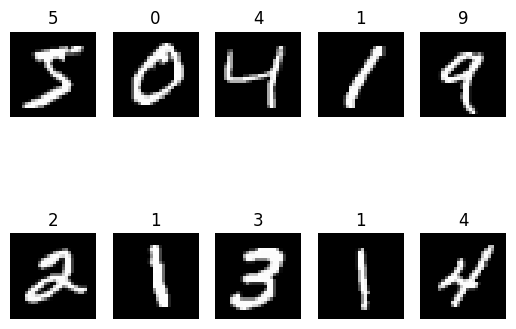

In [3]:
# plot 10 images
import matplotlib.pyplot as plt
import numpy as np
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_trainset[i][0].numpy().reshape(28, 28), cmap='gray')
    plt.title(mnist_trainset[i][1])
    plt.axis('off')

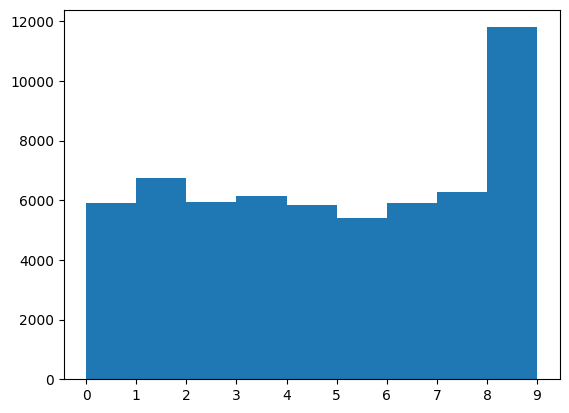

In [4]:
# plot the distribution of labels, with one color for each label
labels = mnist_trainset.targets.numpy()
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.xticks(np.arange(labels.min(), labels.max()+1))
plt.show()

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*7*7, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        x = x.view(-1, 64*7*7)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        # x: batch_size * latent_dim
        return x

In [6]:
encoder = Encoder(1, 128, 2)

In [7]:
print(encoder)

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


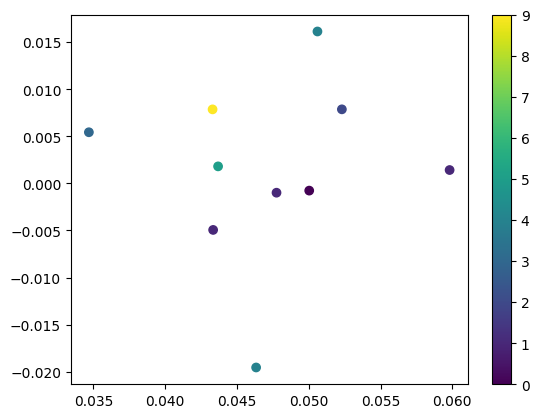

In [8]:
# encode the first 10 images
images = mnist_trainset.data[:10].float().unsqueeze(1)/255
encoder(images)
# plot the encoded images in 2D
encoded_images = encoder(images).detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[:10].numpy())
plt.colorbar()
plt.show()

In [9]:
class SamplingLayer(torch.nn.Module):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class VariationalEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*7*7, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)
        self.sampling = SamplingLayer()

    def forward(self, x):
        original_x = x
        # x: batch_size * 1 * 28 * 28

        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        x = x.view(-1, 64*7*7)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        mu = self.mu(x)
        sigma = self.logvar(x)
        z = self.sampling(mu, sigma)
        # print the shape
        """print(f'original_x: {original_x.shape}')
        print(f'mu: {mu.shape}')
        print(f'sigma: {sigma.shape}')
        print(f'z: {z.shape}')"""

        # x: batch_size * latent_dim
        return z, mu, sigma, original_x

In [10]:
class VariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VariationalDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Fully connected layer
        self.fc1 = torch.nn.Linear(latent_dim, hidden_dim)

        # Transpose Convolutional layers
        self.t_conv1 = torch.nn.ConvTranspose2d(hidden_dim, 64, kernel_size=7, stride=2, padding=1)
        self.t_conv2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=1)
        self.t_conv3 = torch.nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2, padding=1)

    def forward(self, x):
        # x: batch_size * latent_dim
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = x.view(x.size(0), -1, 1, 1)
        # x: batch_size * hidden_dim * 1 * 1
        x = self.t_conv1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 64 * 2 * 2
        x = self.t_conv2(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * 32 * 4 * 4
        x = self.t_conv3(x)
        # x: batch_size * 1 * 4 * 4
        x = torch.sigmoid(x)
        # x: batch_size * 1 * 4 * 4
        return x


In [11]:
variational_encoder = VariationalEncoder(1, 128, 2)
variational_decoder = VariationalDecoder(2, 128, 1)

In [12]:
print(variational_encoder)
print(variational_decoder)

VariationalEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=2, bias=True)
  (logvar): Linear(in_features=128, out_features=2, bias=True)
  (sampling): SamplingLayer()
)
VariationalDecoder(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
)


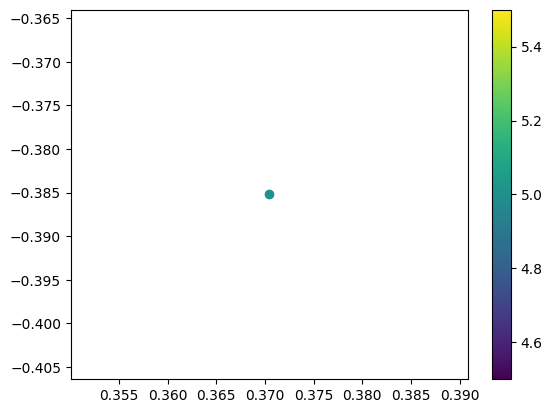

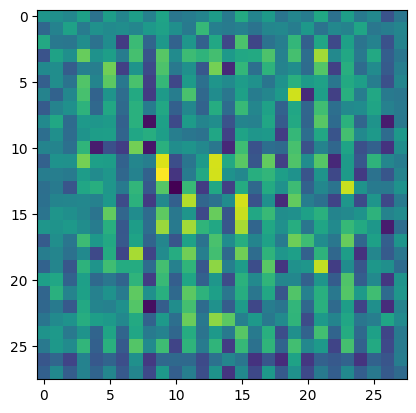

In [13]:
# encode the first 10 images
images = mnist_trainset.data[1].float().unsqueeze(0).unsqueeze(1)/255
encoded = variational_encoder(images)
decoded = variational_decoder(encoded[0])
# plot the encoded images in 2D, and the decoded images
encoded_images = encoded[0].detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[0].numpy())
plt.colorbar()
plt.show()
plt.imshow(decoded[0, 0].detach().numpy())
plt.show()



In [14]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, mu, sigma, original_x = self.encoder(x)
        x = self.decoder(z)
        return x, mu, sigma, original_x

In [15]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(original_x, x):
    return torch.nn.functional.binary_cross_entropy(x, original_x, reduction='sum')

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-3):
    return k1*KL_loss(mu, sigma) + k2*reconstruction_loss(original_x, x)

In [16]:

variational_autoencoder = VariationalAutoEncoder(1, 128, 2)
variational_autoencoder.to(device)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=2, bias=True)
    (logvar): Linear(in_features=128, out_features=2, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (t_conv1): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (t_conv2): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (t_conv3): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  )
)

In [17]:
print(variational_autoencoder)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=2, bias=True)
    (logvar): Linear(in_features=128, out_features=2, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (t_conv1): ConvTranspose2d(128, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (t_conv2): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (t_conv3): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  )
)


In [18]:
batch_size = 256
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=lr)


In [19]:
# take only 10 % of the data

mnist_trainset.data = mnist_trainset.data[:int(len(mnist_trainset.data)/10)]
mnist_trainset.targets = mnist_trainset.targets[:int(len(mnist_trainset.targets)/10)]

mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
for image, label in mnist_trainloader:
    image = image.to(device)
    label = label.to(device)

    break

In [20]:
def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (images, _) in enumerate(mnist_trainloader):
            images = images.float()/255
            x, mu, sigma, original_x = variational_autoencoder(images)
            loss = loss_function(x, original_x, mu, sigma)
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(mnist_trainloader.dataset)}')


In [23]:
train(10)

Epoch: 1, Loss: 0.20063240611553193
Epoch: 2, Loss: 0.021234593431154886
Epoch: 3, Loss: 0.023066476782162983
Epoch: 4, Loss: 0.023706026911735536
Epoch: 5, Loss: 0.024053022861480713
Epoch: 6, Loss: 0.02439800469080607
Epoch: 7, Loss: 0.024499039173126222
Epoch: 8, Loss: 0.024743300914764406
Epoch: 9, Loss: 0.02492303931713104
Epoch: 10, Loss: 0.025002867142359414


6000
6000


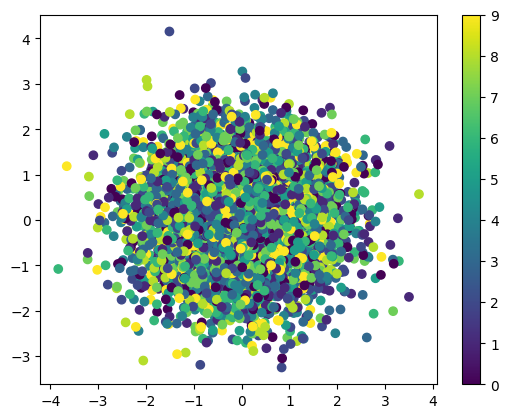

In [25]:
# take all images from the train set
images = mnist_trainset.data.float().unsqueeze(1)/255
print(len(mnist_trainset.data))
print(len(mnist_trainset.targets))
encoded = variational_autoencoder.encoder( images)
decoded = variational_autoencoder.decoder( encoded[0])
# plot the encoded images in 2D, and the decoded images
encoded_images = encoded[0].detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets.numpy())
plt.colorbar()
plt.show()


tensor([[[3.3733e+00, 1.2801e+00, 3.3291e-01, 1.8083e-01, 1.1354e-02,
          4.0905e-03, 1.3028e-03, 6.6870e-03, 7.0426e-04, 2.1217e-04,
          5.4684e-05, 4.6374e-04, 7.3852e-05, 2.7055e-05, 9.5222e-06,
          8.1346e-04, 1.5779e-05, 6.4885e-05, 1.8980e-05, 1.3509e-03,
          1.1999e-03, 2.5901e-03, 1.9458e-03, 1.9431e-02, 2.8413e-02,
          2.6907e-01, 3.1067e-01, 1.4525e+00],
         [2.2134e-01, 3.3597e-02, 2.1608e-03, 1.1269e-03, 5.7661e-06,
          5.0415e-05, 2.2713e-07, 7.8046e-05, 2.9193e-08, 3.1994e-07,
          5.1882e-10, 4.8623e-07, 2.2585e-09, 3.5684e-08, 1.7233e-10,
          6.0837e-07, 6.0113e-10, 9.8615e-08, 3.4827e-10, 8.4016e-06,
          1.0377e-07, 3.2218e-05, 7.6794e-07, 1.6523e-03, 1.0976e-04,
          1.1399e-02, 2.3225e-02, 4.6372e-01],
         [1.2276e-01, 4.5733e-02, 7.6195e-04, 8.7807e-04, 2.1092e-07,
          1.2834e-05, 3.3663e-08, 2.3667e-06, 9.4529e-10, 2.1615e-08,
          1.5770e-11, 7.9791e-08, 4.5652e-12, 1.2826e-09, 3.1125e-

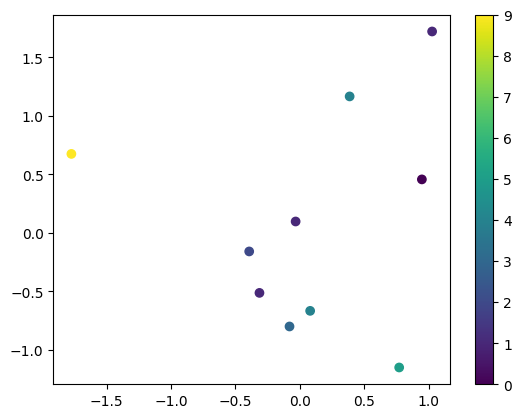

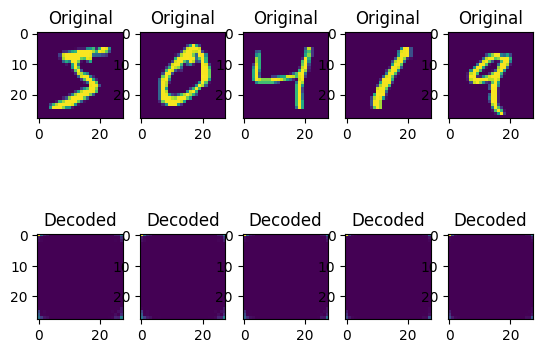

In [30]:
# take 10 images from the train set
images = mnist_trainset.data[:10].float().unsqueeze(1) / 255
encoded = variational_autoencoder.encoder( images)

decoded = variational_autoencoder.decoder( encoded[0]) * 255
print(decoded[0])
# plot the encoded images in 2D, and the decoded images
encoded_images = encoded[0].detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets[:10].numpy())
plt.colorbar()
plt.show()
# plot the decoded images, in a 2 by 5 grid, with the original images on top of each decoded of the decoded images
f, axarr = plt.subplots(2, 5)
for i in range(5):
    # original images
    # write Original on top of the image
    axarr[0, i].set_title('Original')
    axarr[0, i].imshow(images[i, 0].detach().numpy())
    # decoded images
    # write Decoded on top of the image
    axarr[1, i].set_title('Decoded')
    axarr[1, i].imshow(decoded[i, 0].detach().numpy())
plt.show()